In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from time import time
from feature_generators.test_features import *
from feature_generators.helpers import *
import feature_generators.ngram as ngram


GloVe model loaded!


In [2]:
# Load the saved booster model
with open('saved_data/xgb_model.pkl', 'rb') as mod:
    xgb_mod = pickle.load(mod)

In [3]:
def process(data):
    """
    Preprocesses the data provided and generates
    unigrams, bigrams and trigrams.
    Saves the features in the separate columns in the dataframe.
    
    Input: Dataframe
    
    Returns Dataframe
    """
    
    # print (data.iloc[1])
    print ('>>> Data shape: ', data.shape)
    
    t0 = time()
    print("---Generating n-grams Features!---")
    print ("Generating unigram")
    data["Headline_unigram"] = data["Headline"].map(lambda x: preprocess_data(x))
    data["articleBody_unigram"] = data["articleBody"].map(lambda x: preprocess_data(x))
    
    print ("Generating bigram")
    join_str = "_"
    data["Headline_bigram"] = data["Headline_unigram"].map(lambda x: ngram.getBigram(x, join_str))
    data["articleBody_bigram"] = data["articleBody_unigram"].map(lambda x: ngram.getBigram(x, join_str))

    print ("Generating trigram")
    join_str = "_"
    data["Headline_trigram"] = data["Headline_unigram"].map(lambda x: ngram.getTrigram(x, join_str))
    data["articleBody_trigram"] = data["articleBody_unigram"].map(lambda x: ngram.getTrigram(x, join_str))

    print("---n-gram Features generated---")
    print("Time taken: {} seconds\n".format(time() - t0))
    
    return data


In [4]:
def build_test_data(data):
    """
    Generates various features needed to predict
    the class of the news.
    
    Input: DataFrame
    Returns Array of generated features.
    """

    data = process(data)
    
    generators = [CountFeatureGenerator,
                  TfidfFeatureGenerator,
                  # SvdFeatureGenerator,
                  ReadabilityFeatureGenerator,
                  Word2VecFeatureGenerator,
                  SentimentFeatureGenerator
                 ]
    
    # Class generators one by one to generate features
    features = [feature for generator in generators for feature in generator(data)]
    print("Total number of raw features: {}".format(len(features)))
    
    # Stack and return the features
    return np.hstack(features)

In [5]:
def check(news):
    """
    Predicts the probable class and corresponding probabilites
    of the news belonging to a certian clas
    
    Input: DataFrame of news: Headline and Article body only
    Returns DataFrame with class predictions
    """

    test_x = build_test_data(news)
    
    # Save feature_vector for quick debugging
    with open('tmp/feature_vector', 'wb') as fv:
        pickle.dump(test_x, fv)
        

    dtest = xgb.DMatrix(test_x)
    print("Total Feature count in the test set: ", len(dtest.feature_names))
    
    # Use Booster to predict class
    pred_prob_y = xgb_mod.predict(dtest).reshape(test_x.shape[0], 4) # predicted probabilities
    pred_y = np.argmax(pred_prob_y, axis=1)

    LABELS = ['reliable', 'unreliable']
    predicted = [LABELS[int(a)] for a in pred_y]

    # print (predicted)
    print ('pred_y.shape: ', pred_y.shape)
    predicted = [LABELS[int(a)] for a in pred_y]

    news['preds'] = predicted
    news['Reliable'] = pred_prob_y[:, 0]
    news['Unreliable'] = pred_prob_y[:, 1]
    
    return news

In [21]:
data = pd.read_csv("../Datasets/LittleSplits/fake_little.csv")
data.drop(columns=['type', 'authors'], inplace=True)
data.columns = ['articleBody', 'Headline']

df_output = check(data)
df_output

articleBody    Water Cooler 1/25/18 Open Thread; Fake News ? ...
Headline       Water Cooler 1/25/18 Open Thread; Fake News ? ...
Name: 1, dtype: object
>>> Data shape:  (100, 2)
---Generating n-grams Features!---
Generating unigram
Generating bigram
Generating trigram
---n-gram Features generated---
Time taken: 0.6839399337768555 seconds


---Generating Counting Features:---
xBasicCounts.shape:  (100, 41)
---Counting Features is complete---
Time taken 0.2024707794189453 seconds


---Generating TFIDF Features:---
xHeadlineTfidf.shape: (100, 859153)
xBodyTfidf.shape:  (100, 859153)
simTfidf.shape:  (100, 1)
---TFIDF Features is complete---
Time taken 1.715486764907837 seconds


---Generating Readability Features:---
xReadable.shape:  (100, 12)
---Readability Features is complete---
Time taken 2.8884401321411133 seconds


---Generating Word2Vector Features:---
GloVe model loaded!
headlineVec.shape:  (100, 50)
bodyVec.shape:  (100, 50)
simVec.shape:  (100, 1)
---Word2Vector Features is co

,articleBody,Headline,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,count_of_Headline_unigram,count_of_unique_Headline_unigram,...,gunning_fog,i_me_myself,punct,lexical_diversity,Headline_unigram_vec,articleBody_unigram_vec,headline_sents,preds,Reliable,Unreliable
0,Headline: Bitcoin & Blockchain Searches Exceed...,Surprise: Socialist Hotbed Of Venezuela Has Lo...,"[surpris, socialist, hotb, venezuela, lost, ha...","[headlin, bitcoin, blockchain, search, exceed,...","[surpris_socialist, socialist_hotb, hotb_venez...","[headlin_bitcoin, bitcoin_blockchain, blockcha...","[surpris_socialist_hotb, socialist_hotb_venezu...","[headlin_bitcoin_blockchain, bitcoin_blockchai...",7,7,...,20.17,1,32,24.215385,"[surprise, socialist, hotbed, of, venezuela, h...","[headline, bitcoin, blockchain, searches, exce...",[Surprise: Socialist Hotbed Of Venezuela Has L...,unreliable,0.007195,0.992796
1,Water Cooler 1/25/18 Open Thread; Fake News ? ...,Water Cooler 1/25/18 Open Thread; Fake News ? ...,"[water, cooler, 25, 18, open, thread, fake, ne...","[water, cooler, 25, 18, open, thread, fake, ne...","[water_cooler, cooler_25, 25_18, 18_open, open...","[water_cooler, cooler_25, 25_18, 18_open, open...","[water_cooler_25, cooler_25_18, 25_18_open, 18...","[water_cooler_25, cooler_25_18, 25_18_open, 18...",21,19,...,24.08,2,86,87.460526,"[water, cooler, 25, 18, open, thread, fake, ne...","[water, cooler, 25, 18, open, thread, fake, ne...",[Water Cooler 1/25/18 Open Thread; Fake News ?...,unreliable,0.001809,0.998187
2,Veteran Commentator Calls Out the Growing “Eth...,Veteran Commentator Calls Out the Growing “Eth...,"[veteran, comment, call, grow, ethnon, fox, ne...","[veteran, comment, call, grow, ethnon, fox, ne...","[veteran_comment, comment_call, call_grow, gro...","[veteran_comment, comment_call, call_grow, gro...","[veteran_comment_call, comment_call_grow, call...","[veteran_comment_call, comment_call_grow, call...",8,8,...,26.01,7,65,43.666667,"[veteran, commentator, calls, out, the, growin...","[veteran, commentator, calls, out, the, growin...",[Veteran Commentator Calls Out the Growing “Et...,unreliable,0.001132,0.998866
3,"Lost Words, Hidden Words, Otters, Banks and Bo...","Lost Words, Hidden Words, Otters, Banks and Books","[lost, word, hidden, word, otter, bank, book]","[lost, word, hidden, word, otter, bank, book, ...","[lost_word, word_hidden, hidden_word, word_ott...","[lost_word, word_hidden, hidden_word, word_ott...","[lost_word_hidden, word_hidden_word, hidden_wo...","[lost_word_hidden, word_hidden_word, hidden_wo...",7,6,...,15.97,13,83,51.242857,"[lost, words, hidden, words, otters, banks, an...","[lost, words, hidden, words, otters, banks, an...","[Lost Words, Hidden Words, Otters, Banks and B...",unreliable,0.005977,0.994008
4,Red Alert: Bond Yields Are SCREAMING “Inflatio...,Red Alert: Bond Yields Are SCREAMING “Inflatio...,"[red, alert, bond, yield, scream, inflat, come]","[red, alert, bond, yield, scream, inflat, come...","[red_alert, alert_bond, bond_yield, yield_scre...","[red_alert, alert_bond, bond_yield, yield_scre...","[red_alert_bond, alert_bond_yield, bond_yield_...","[red_alert_bond, alert_bond_yield, bond_yield_...",7,7,...,17.18,0,11,10.616667,"[red, alert, bond, yields, are, screaming, inf...","[red, alert, bond, yields, are, screaming, inf...",[Red Alert: Bond Yields Are SCREAMING “Inflati...,unreliable,0.000282,0.999717
5,Scientists move Doomsday Clock ahead by 30 sec...,Scientists move Doomsday Clock ahead by 30 sec...,"[scientist, move, doomsday, clock, ahead, 30, ...","[scientist, move, doomsday, clock, ahead, 30, ...","[scientist_move, move_doomsday, doomsday_clock...","[scientist_move, move_doomsday, doomsday_clock...","[scientist_move_doomsday, move_doomsday_clock,...","[scientist_move_doomsday, move_doomsday_clock,...",15,15,...,23.52,2,247,211.411765,"[scientists, move, doomsday, clock, ahead, by,...","[scientists, move, doomsday, clock, ahe

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

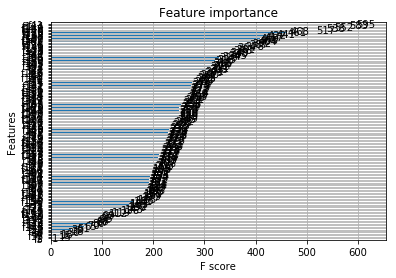

In [17]:
# Visualize the importance of each feature in the model.
xgb.plot_importance(xgb_mod, height=0.2)

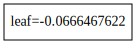

In [15]:
# Make deciscion tree
xgb.to_graphviz(xgb_mod, num_trees=2)

## For quick debugging.

In [18]:
import pickle
import xgboost as xgb

with open('saved_data/xgb_model.pkl', 'rb') as mod:
    xgb_mod = pickle.load(mod)

with open('tmp/feature_vector', 'rb') as fv:
    test_x = pickle.load(fv)

dtest = xgb.DMatrix(test_x)

print("Total Feature count in the test set: ", len(dtest.feature_names))

dtest = xgb.DMatrix(test_x)
print("Total Feature count in the test set: ", len(dtest.feature_names))

# Use Booster to predict class
pred_prob_y = xgb_mod.predict(dtest).reshape(test_x.shape[0], 4) # predicted probabilities
pred_y = np.argmax(pred_prob_y, axis=1)

LABELS = ['reliable', 'unreliable']
predicted = [LABELS[int(a)] for a in pred_y]

# print (predicted)
print ('pred_y.shape: ', pred_y.shape)
predicted = [LABELS[int(a)] for a in pred_y]

news['preds'] = predicted
news['Reliable'] = pred_prob_y[:, 0]
news['Unreliable'] = pred_prob_y[:, 1]


Total Feature count in the test set:  163
Total Feature count in the test set:  163
pred_y.shape:  (100,)
